In [1]:
!pip install easyocr transformers --quiet
!pip install opencv-python-headless
!pip install torch torchvision torchaudio
!pip install scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import joblib
import os

In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "AI/lib"
assert GOOGLE_DRIVE_PATH_AFTER_MYDRIVE is not None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['app.py']


In [7]:
class RuleAugmentedMLP(nn.Module):
    def __init__(self, input_dim):
        super(RuleAugmentedMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.2)
        self.output = nn.Linear(32, 3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(F.leaky_relu(self.fc3(x)))
        return self.output(x)

In [8]:
# New: Stricter labels
def generate_sample():
    calories = random.randint(50, 500)
    fat = random.randint(0, 25)
    sat_fat = random.randint(0, 10)
    sodium = random.randint(0, 1000)
    sugar = random.randint(0, 40)
    fiber = random.randint(0, 10)
    protein = random.randint(0, 20)

    high_sodium = int(sodium > 400)
    high_sugar = int(sugar > 20)
    high_sat_fat = int(sat_fat > 5)
    good_fiber = int(fiber >= 5)

    features = [calories, fat, sat_fat, sodium, sugar, fiber, protein,
                high_sodium, high_sugar, high_sat_fat, good_fiber]

    # New scoring system
    warning_score = (
        (sodium > 400) +
        (sugar > 25) +
        (sat_fat > 5) +
        (fat > 20) +
        (fiber < 2)
    )

    if warning_score >= 3:
        label = 2  # Avoid
    elif warning_score == 2:
        label = 1  # Caution
    else:
        label = 0  # Healthy

    return features, label

In [9]:
# Add noise to features
def generate_noisy_sample():
    features, label = generate_sample()
    noise = np.random.normal(0, 5, size=len(features))
    features = np.array(features) + noise
    return features.tolist(), label

In [10]:
# Generate 5,000 samples (70% clean + 30% noisy)
X, y = [], []
for _ in range(7000):
    f, l = generate_sample()
    X.append(f)
    y.append(l)
for _ in range(3000):
    f, l = generate_noisy_sample()
    X.append(f)
    y.append(l)

X = np.array(X, dtype=np.float32)
y = np.array(y)

In [11]:
# Normalize + split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val)

# Class weights
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
weights = torch.tensor(weights, dtype=torch.float32)

In [12]:
model = RuleAugmentedMLP(input_dim=11)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.003, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=weights)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

best_val_acc = 0
early_stopping_counter = 0
train_losses, val_losses = [], []

for epoch in range(200):
    # Training
    model.train()
    optimizer.zero_grad()
    out = model(X_train_tensor)
    loss = criterion(out, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_out = model(X_val_tensor)
        val_loss = criterion(val_out, y_val_tensor)
        val_losses.append(val_loss.item())
        preds = torch.argmax(val_out, dim=1)
        acc = (preds == y_val_tensor).float().mean()

    scheduler.step(val_loss.item())

    if acc > best_val_acc:
        best_val_acc = acc
        early_stopping_counter = 0
        torch.save(model.state_dict(), "/content/best_model.pth")
    else:
        early_stopping_counter += 1

    if (epoch + 1) % 25 == 0:
        print(f"Epoch {epoch+1} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f} | Val Acc: {acc.item():.4f}")

    if early_stopping_counter > 15:
        print("🛑 Early stopping triggered.")
        break

Epoch 25 | Train Loss: 0.7256 | Val Loss: 0.7325 | Val Acc: 0.6455
Epoch 50 | Train Loss: 0.6171 | Val Loss: 0.6369 | Val Acc: 0.6910
Epoch 75 | Train Loss: 0.5077 | Val Loss: 0.5571 | Val Acc: 0.7415
Epoch 100 | Train Loss: 0.4110 | Val Loss: 0.4892 | Val Acc: 0.7795
Epoch 125 | Train Loss: 0.3389 | Val Loss: 0.4553 | Val Acc: 0.8160
Epoch 150 | Train Loss: 0.2871 | Val Loss: 0.4467 | Val Acc: 0.8245
Epoch 175 | Train Loss: 0.2667 | Val Loss: 0.4521 | Val Acc: 0.8280
🛑 Early stopping triggered.



🔍 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.88      0.86      0.87       789
     Caution       0.78      0.78      0.78       725
       Avoid       0.82      0.84      0.83       486

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



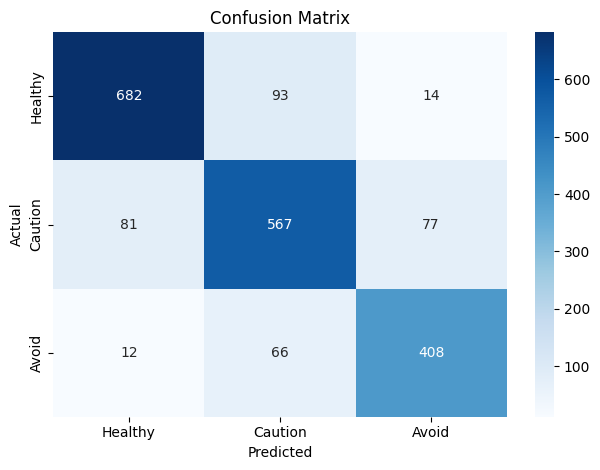

In [13]:
# Reload best model
model.load_state_dict(torch.load("/content/best_model.pth"))
model.eval()

with torch.no_grad():
    val_out = model(X_val_tensor)
    preds = torch.argmax(val_out, dim=1)

# Classification Report
print("\n🔍 Classification Report:")
print(classification_report(y_val_tensor.numpy(), preds.numpy(), target_names=['Healthy', 'Caution', 'Avoid']))

# Confusion Matrix
cm = confusion_matrix(y_val_tensor.numpy(), preds.numpy())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Caution', 'Avoid'], yticklabels=['Healthy', 'Caution', 'Avoid'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

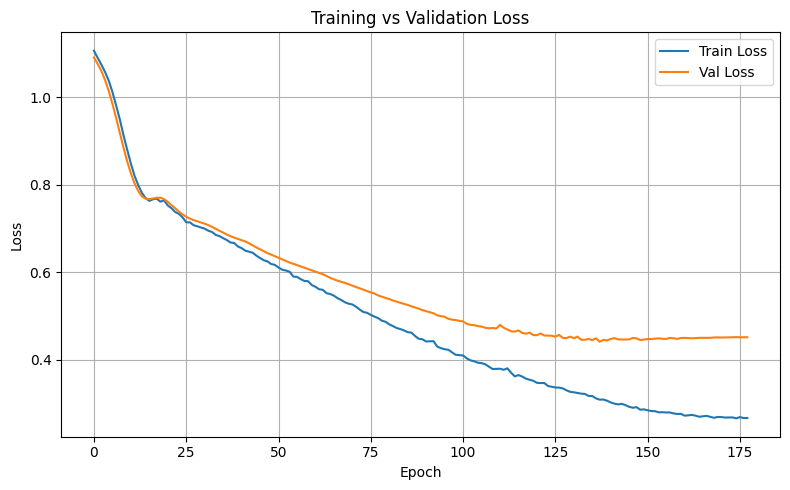

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# Optional: Save to Google Drive
save_path = "/content/drive/MyDrive/AI"
os.makedirs(save_path, exist_ok=True)

torch.save(model.state_dict(), os.path.join(save_path, 'best_model.pth'))
joblib.dump(scaler, os.path.join(save_path, 'scaler.pkl'))

print("✅ Model & scaler saved to Drive.")

✅ Model & scaler saved to Drive.


In [16]:
!pip install streamlit pyngrok --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 104.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.1 MB/s eta 0:00:00


In [17]:
!rm -rf ~/.ngrok2

In [18]:
!ngrok config add-authtoken "2ve75nXvSJgwsKys9Tz7WM4cL3O_25ouwxzgnFbeZyqGsGUbD" #Add a personal token

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [19]:
from pyngrok import ngrok

!streamlit run '/content/drive/MyDrive/AI/lib/app.py' &>/content/logs.txt &
public_url = ngrok.connect(8501)
print("🔗 Your website is live at:", public_url.public_url)

🔗 Your website is live at: https://a603-35-243-172-1.ngrok-free.app
